# Reliability calculations with FORM

In this example, we will demonstrate how to perform reliability calculations using the First Order Reliability Method (FORM).

### Define model

First, let's import the necessary classes:

In [1]:
from probabilistic_library import ReliabilityProject, DistributionType, ReliabilityMethod, StartMethod

Next, we define a simple limit state function: 

$Z = 1.9 - (a+b)$

This is a linear model involving two variables, $a$ and $b$.

In [2]:
from utils.models import linear_a_b

To perform a reliability analysis, we create a reliability project and specify the limit state function (model):

In [3]:
project = ReliabilityProject()
project.model = linear_a_b

project.model.print()

Model linear_a_b:
Input parameters:
  a
  b
Output parameters:
  Z


We assume that variables $a$ and $b$ are uniformly distributed over the interval $[-1, 1]$. This is defined as follows:

In [4]:
project.variables["a"].distribution = DistributionType.uniform
project.variables["a"].minimum = -1
project.variables["a"].maximum = 1

project.variables["b"].distribution = DistributionType.uniform
project.variables["b"].minimum = -1
project.variables["b"].maximum = 1

### Define reliability method

We use the reliability method `form`. We choose the calculation settings: `relaxation_factor`, `maximum_iterations` and `variation_coefficient`. 

In [5]:
project.settings.reliability_method = ReliabilityMethod.form

project.settings.relaxation_factor = 0.15
project.settings.maximum_iterations = 50
project.settings.variation_coefficient = 0.02

We can also define the start method, with the following options available: `ray_search`, `one`, `fixed_value`, `sensitivity_search`, and `sphere_search`. If the fixed_value option is selected, a start value must be specified for each variable.

In [6]:
# fixed_value
project.settings.start_method = StartMethod.fixed_value
project.settings.stochast_settings["a"].start_value = 1.2
project.settings.stochast_settings["b"].start_value = 2.4

# in this example we choose the ray_search method
project.settings.start_method = StartMethod.ray_search

### Perform calculations

We use `project.run()` to execute the reliability analysis:

In [7]:
project.run()

The results are written to `project.design_point` and consist of:
* reliability index $\beta$
* failure probability $P_f$
* influence coefficients $\alpha$-values
* design point $x$-values
* information about the convergence of FORM


Reliability (FORM)
 Reliability index = 2.773
 Probability of failure = 0.0028
 Convergence = 0.0088 (converged)
 Model runs = 54
Alpha values:
 a: alpha = -0.7071, x = 0.9501
 b: alpha = -0.7071, x = 0.9501

Contributing design points:
  Reliability (Start point)
   Reliability index = 3.6937
   Probability of failure = 1.104871e-04
   Model runs = 11
  Alpha values:
   a: alpha = -0.4472, x = 0.9014
   b: alpha = -0.8944, x = 0.999



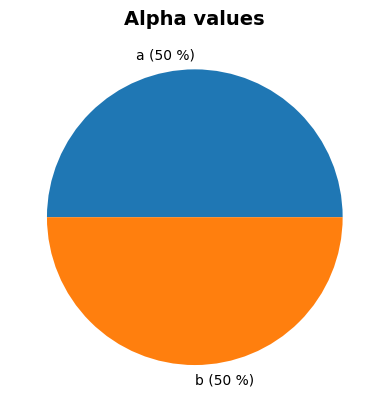

In [8]:
project.design_point.print()
project.design_point.plot_alphas()

### Correlated variables

In the above example, variables $a$ and $b$ are independent. However, it is also possible to introduce a correlation between $a$ and $b$. The example below demonstrates this with a partial correlation coefficient of $0.8$.

Reliability (FORM)
 Reliability index = 2.0646
 Probability of failure = 0.0195
 Convergence = 0.0084 (converged)
 Model runs = 39
Alpha values:
 a: alpha = -0.9565, x = 0.9517
 b: alpha = -0.2916, x = 0.9478

Contributing design points:
  Reliability (Start point)
   Reliability index = 3.6937
   Probability of failure = 1.104871e-04
   Model runs = 11
  Alpha values:
   a: alpha = -0.4472, x = 0.9014
   b: alpha = -0.8944, x = 0.999



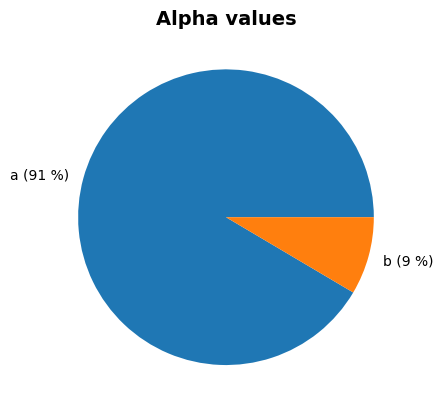

In [9]:
project.correlation_matrix["a", "b"] = 0.8
project.run()

project.design_point.print()
project.design_point.plot_alphas()